# Synthesize search sessions from signals

This notebook synthesizes search sessions from the CTR of the clicked documents on each search result. It's assumed that if you order results by CTR, that roughly captures the source search system's relevance ranking in aggregate (including all the position and other biases). 

You can then check to see if the document is above or below average for that rank position (using a z score). You can then use that z score to translate that document to any other position. 

This is intended more for creating fake search session data for examples in AI Powered Search, and not a replacement for actually logging real search sessions in your search system.

In [175]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
import os
from IPython.core.display import display,HTML

signals = pd.read_csv('../data/retrotech/signals.csv')

#seed=8675309
#random.seed(seed)
#np.random.seed(seed)

DOCS_PER_SESSION=30 # how many docs in one search page view?
NUM_SESSIONS=5000 # how many sessions to generate for each query?

# Generate search sessions for these queries
QUERIES_TO_SIMULATE=['dryer', 'iphone', 'nook', 'kindle', 
                     'lcd tv', 'ipad', 'headphones', 'macbook',
                     'how i met your mother', 'star wars', 'star trek',
                     'blue ray', 'bluray']

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Gather queries occuring above a certain threshold

In [176]:
MIN_QUERY_EVENTS=100

queries = signals[signals['type'] == 'query']
popular_queries = queries.groupby('target').count() \
                         .rename(columns={'query_id': 'query_count'}) \
                         .sort_values('query_count', ascending=False)
popular_queries = popular_queries[popular_queries['query_count'] > MIN_QUERY_EVENTS].index.to_list()
pop_query_events = signals[signals['type'] == 'query'][signals['target'].isin(popular_queries)]
query_events = pop_query_events[['query_id', 'target']].rename(columns={'target': 'query'})

# Cleanup by lowercasing
# This step has its pros and cons. We might miss some info that case gives us, but it also
# aggregates more signal per query
query_events['query'] = query_events['query'].apply(lambda q: q.lower())
query_event_counts = query_events.groupby('query')['query_id'].count().reset_index().sort_values('query_id', ascending=False)
query_event_counts[query_event_counts['query'].str.contains('blue ray')]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,query,query_id
104,blue ray,276


# Join click events with corresponding queries into one table

In [177]:
clicks = signals[signals['type'] == 'click']
click_events = clicks[['query_id', 'target']].rename(columns={'target': 'clicked_doc_id'})
clicks_per_query = query_events.merge(click_events, 
                                      on='query_id', 
                                      how='left')
clicks_per_query['clicked_doc_id'] = clicks_per_query['clicked_doc_id'].fillna(0)
# clicks_per_query.groupby('query').count().sort_values('query_id', ascending=False)

clicks_per_query

,query_id,query,clicked_doc_id
0,u2_0_1,nook,9781400532650
1,u2_1_2,rca,883393001119
2,u3_0_1,macbook,885909464036
3,u4_0_1,tv antenna,079000334835
4,u7_0_1,camcorder,027242821866
...,...,...,...
488539,u744327_0_1,dre beats,848447000135
488540,u744328_0_1,sirius radio,884720004032
488541,u744330_0_1,usb drive,718037770604
488542,u744331_0_1,iphone 4s,885909538027


# Compute a CTR for each query/doc pair

0.15889705213356384
0.10964912280701754
0.07842453816660858
0.059931506849315065


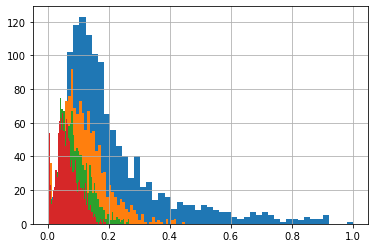

In [178]:
# tot number of queries (denom if CTR)
denominator = query_events.groupby('query').count().rename(columns={'query_id': 'tot_query_count'})

# click counts per doc in query
click_thru_rate = clicks_per_query.groupby(['query', 'clicked_doc_id']).count().rename(columns={'query_id':'click_count'}).reset_index()
click_thru_rate = click_thru_rate.merge(denominator, on='query', how='left')

click_thru_rate['ctr'] = click_thru_rate['click_count'] / click_thru_rate['tot_query_count']
click_thru_rate = click_thru_rate.sort_values(['query', 'ctr'], ascending=[True, False])

# Get rid of doc_id 0, which is all the queries with no clicks
# We treat these as a canonical ranking from the source system, assume it's relatively
# highly tuned and the source CTRs are pretty reasonably close to actual relevance ranking
# in the source system. Of course this is a dubious assumption in a real search system, 
# but for our purposes - to synthesize reasonable looking search sessions - it will serve
canonical_rankings = click_thru_rate[click_thru_rate['clicked_doc_id'] != 0].reset_index()


# Just for display and sanity checking
print(canonical_rankings.groupby('query').nth(0)['ctr'].median())
canonical_rankings.groupby('query').nth(0)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(1)['ctr'].median())
canonical_rankings.groupby('query').nth(1)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(2)['ctr'].median())
canonical_rankings.groupby('query').nth(2)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(3)['ctr'].median())
canonical_rankings.groupby('query').nth(3)['ctr'].hist(bins=50)

# Compute stats of each CTR position

What's the mean, median, std deviaton, etc of CTR in each position? This lets us synthesize sessions assuming the above average or below average CTR is an indication of above or below average relevance

In [179]:
canonical_rankings['rank'] = canonical_rankings.groupby('query').cumcount()

# Idea
# Compute neg z scores for items below mean and positive z scores for items above mean
# but negative z scores are fit to a distribution of only the negative values and the negative values + mean
# similarly for positive values

max_depth = canonical_rankings['rank'].max()
for i in range(0, max_depth):
    idxs = canonical_rankings[canonical_rankings['rank'] == i].index
   
    # Mean based statistics
    canonical_rankings.loc[idxs, 'posn_ctr_mean'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mean()
    canonical_rankings.loc[idxs, 'posn_ctr_std'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].std()
 
    # Median based statistics (less outlier prone)
    canonical_rankings.loc[idxs, 'posn_ctr_median'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].median()
    canonical_rankings.loc[idxs, 'posn_ctr_mad'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mad()

canonical_rankings['ctr_std_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_mean']) / canonical_rankings['posn_ctr_std']
canonical_rankings['ctr_mod_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_median']) / canonical_rankings['posn_ctr_mad']

orig_dryer = canonical_rankings[canonical_rankings['query'] == 'dryer'].head(20)
orig_dryer

,index,query,clicked_doc_id,click_count,tot_query_count,ctr,rank,posn_ctr_mean,posn_ctr_std,posn_ctr_median,posn_ctr_mad,ctr_std_z_score,ctr_mod_z_score
15580,15844,dryer,12505451713,20,246,0.081301,0,0.215521,0.172469,0.158897,0.124872,-0.778227,-0.621404
15581,15893,dryer,883929085118,18,246,0.073171,1,0.121488,0.070496,0.109649,0.054231,-0.685393,-0.672647
15582,15887,dryer,883049066905,16,246,0.065041,2,0.087093,0.048757,0.078425,0.038821,-0.452290,-0.344763
15583,15854,dryer,36172950027,13,246,0.052846,3,0.065306,0.036182,0.059932,0.028924,-0.344385,-0.244987
15584,15870,dryer,74108056764,13,246,0.052846,4,0.051849,0.030129,0.048343,0.024117,0.033090,0.186711
15585,15872,dryer,77283045400,13,246,0.052846,5,0.041020,0.024764,0.039578,0.019993,0.477524,0.663618
15586,15883,dryer,783722274422,13,246,0.052846,6,0.031860,0.019346,0.031660,0.015932,1.084741,1.329765
15587,15880,dryer,665331101927,11,246,0.044715,7,0.026049,0.016632,0.025751,0.013968,1.122345,1.357717
15588,15848,dryer,14381196320,9,246,0.036585,8,0.021772,0.014593,0.020859,0.012446,1.015130,1.263529
15589,15871,dryer,74108096487,9,246,0.036585,9,0.018520,0.012575,0.017204,0.010934,1.436546,1.772473


# Create a single search session

Given statistics on CTR, assume the search engine returns a shuffled list of results, and recompute likely CTR for each position. Then randomly select whether there was a click

In [180]:
def dest_rankings(n, query, baselines):
    if query not in baselines:
        shuffled = canonical_rankings[canonical_rankings['query'] == query]
        shuffled = shuffled[['posn_ctr_mean', 'posn_ctr_std', 'rank', 'posn_ctr_mad', 'posn_ctr_median']]\
                    .rename(columns={'rank': 'dest_rank'})
        shuffled = shuffled[shuffled['dest_rank'] < n].sample(frac=1)
        baselines[query] = shuffled    
    return baselines[query]

def slightly_random_ranking(n, query, baselines):
    top_n = dest_rankings(n, query, baselines).copy()
    to_swap = list(range(0,20))
    random.shuffle(to_swap)
    to_swap = to_swap[:8]
    
    for a, b in zip(to_swap, to_swap[1:]):
        b_val = top_n.iloc[b]
        a_val = top_n.iloc[a].copy()
        top_n.iloc[a] = b_val
        top_n.iloc[b] = a_val
    
    # Swap a few posns
    return top_n

def synthesize_session(query, sess_id, baselines):
    posn_weights=[]
    
    canonical = canonical_rankings[canonical_rankings['query'] == query][canonical_rankings['rank'] < DOCS_PER_SESSION]
    
    top_n = slightly_random_ranking(DOCS_PER_SESSION, query, baselines)
    
    
    
    shuffled = top_n.rename(columns={'posn_ctr_std': 'dest_ctr_std',
                         'posn_ctr_mean': 'dest_ctr_mean',
                         'posn_ctr_mad': 'dest_ctr_mad',
                         'posn_ctr_median': 'dest_ctr_median'})
    shuffled = shuffled.reset_index(drop=True).reset_index().rename(columns={'index': 'rank'})
    shuffled = shuffled.merge(canonical, on='rank', how='left')
    shuffled['dest_ctr_median_based'] = (shuffled['ctr_mod_z_score'] * shuffled['dest_ctr_mad']) + (shuffled['dest_ctr_median'])
    shuffled['dest_ctr_mean_based'] = (shuffled['ctr_std_z_score'] * shuffled['dest_ctr_std']) + (shuffled['dest_ctr_mean'])
    shuffled['draw'] = np.random.rand(len(shuffled))
    shuffled['clicked'] = shuffled['draw'] < shuffled['dest_ctr_mean_based']
    shuffled['sess_id'] = sess_id

    return shuffled

baselines={}

In [181]:
synthesize_session('dryer', 1, baselines)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,rank,dest_ctr_mean,dest_ctr_std,dest_rank,dest_ctr_mad,dest_ctr_median,index,query,clicked_doc_id,click_count,...,posn_ctr_std,posn_ctr_median,posn_ctr_mad,ctr_std_z_score,ctr_mod_z_score,dest_ctr_median_based,dest_ctr_mean_based,draw,clicked,sess_id
0,0,0.005123,0.002433,27.0,0.001776,0.004444,15844,dryer,12505451713,20,...,0.172469,0.158897,0.124872,-0.778227,-0.621404,0.003341,0.003229,0.664851,False,1
1,1,0.006111,0.003424,22.0,0.002703,0.004651,15893,dryer,883929085118,18,...,0.070496,0.109649,0.054231,-0.685393,-0.672647,0.002833,0.003764,0.100723,False,1
2,2,0.031860,0.019346,6.0,0.015932,0.031660,15887,dryer,883049066905,16,...,0.048757,0.078425,0.038821,-0.452290,-0.344763,0.026167,0.023110,0.749103,False,1
3,3,0.004872,0.002181,29.0,0.001557,0.004405,15854,dryer,36172950027,13,...,0.036182,0.059932,0.028924,-0.344385,-0.244987,0.004024,0.004121,0.506594,False,1
4,4,0.008799,0.005915,16.0,0.005005,0.005435,15870,dryer,74108056764,13,...,0.030129,0.048343,0.024117,0.033090,0.186711,0.006369,0.008994,0.645359,False,1
5,5,0.011451,0.008090,13.0,0.007052,0.008439,15872,dryer,77283045400,13,...,0.024764,0.039578,0.019993,0.477524,0.663618,0.013118,0.015314,0.938898,False,1
6,6,0.004991,0.002298,28.0,0.001657,0.004425,15883,dryer,783722274422,13,...,0.019346,0.031660,0.015932,1.084741,1.329765,0.006629,0.007484,0.588894,False,1
7,7,0.009547,0.006554,15.0,0.005619,0.006536,15880,dryer,665331101927,11,...,0.016632,0.025751,0.013968,1.122345,1.357717,0.014166,0.016903,0.126852,False,1
8,8,0.006741,0.004042,20.0,0.003251,0.004808,15848,dryer,14381196320,9,...,0.014593,0.020859,0.012446,1.015130,1.263529,0.008916,0.010844,0.622237,False,1
9,9,0.012683,0.009012,12.0,0.007897,0.009276,15871,dryer,74108096487,9,...,0.012575,0.017204,0.010934,1.436546,1.772473,0.023274,0.025629,0.666952,False,1


# Randomly sample source signals, generate new sessions

In [182]:
from time import perf_counter 
sess_id = 0

#for query in QUERIES_TO_SIMULATE:
for query in ['dryer']:
    
    session_dfs=[]
    t1_start = perf_counter()  
    if len(canonical_rankings[canonical_rankings['query'] == query]) > 0:
        for i in range(0, NUM_SESSIONS):
            session_dfs.append(synthesize_session(query, sess_id, baselines))
            sess_id+=1
            if (sess_id % 500 == 0):
                print("Created Sessions %s Last Query %s Elapsed %s" % (sess_id, query, perf_counter()-t1_start))
    else:
        print("Query %s not available" % query)

    sessions = pd.concat(session_dfs)
    sessions = sessions.sort_values(['sess_id', 'dest_rank'])
    sessions[['sess_id', 'query', 'dest_rank', 'clicked_doc_id', 'clicked']] \
        .rename(columns={'dest_rank': 'rank'}) \
        .to_csv("%s_sessions.gz" % query, compression='gzip', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Created Sessions 500 Last Query dryer Elapsed 10.396458700066432
Created Sessions 1000 Last Query dryer Elapsed 20.70228330011014
Created Sessions 1500 Last Query dryer Elapsed 31.081856100005098
Created Sessions 2000 Last Query dryer Elapsed 41.70352660003118
Created Sessions 2500 Last Query dryer Elapsed 52.1875013000099
Created Sessions 3000 Last Query dryer Elapsed 62.23087950004265
Created Sessions 3500 Last Query dryer Elapsed 72.40120730001945
Created Sessions 4000 Last Query dryer Elapsed 82.64537190005649
Created Sessions 4500 Last Query dryer Elapsed 92.73562240006868
Created Sessions 5000 Last Query dryer Elapsed 102.73251730005722


In [183]:
def all_sessions():
    import glob
    return pd.concat([pd.read_csv(f, compression='gzip')
                      for f in glob.glob('*_sessions.gz')])

sessions = all_sessions()
sessions

,sess_id,query,rank,clicked_doc_id,clicked
0,0,dryer,0.0,36725578241,True
1,0,dryer,1.0,84691226703,False
2,0,dryer,2.0,12505382925,True
3,0,dryer,3.0,74108056764,False
4,0,dryer,4.0,48231011198,False
...,...,...,...,...,...
99995,59999,blue ray,15.0,23942972389,False
99996,59999,blue ray,16.0,786936817232,False
99997,59999,blue ray,17.0,36725608443,False
99998,59999,blue ray,18.0,36725608511,False


In [184]:
def fetch_products(doc_ids):
    import requests
    doc_ids = ["%s" % doc_id for doc_id in doc_ids]
    query = "upc:( " + " OR ".join(doc_ids) + " )"
    params = {'q':  query, 'wt': 'json', 'rows': len(doc_ids)}
    resp = requests.get('http://aips-solr:8983/solr/products/select', params=params)
    df = pd.DataFrame(resp.json()['response']['docs'])
    df['upc'] = df['upc'].astype('int64')
    return df

products = fetch_products(doc_ids=sessions['clicked_doc_id'].unique())
products

,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,883393003458,"RCA - 46"" Class - LCD - 1080p - 60Hz - HDTV",RCA,\N,This HDTV showcases stunning images up to 1080...,953d1c22-88d7-4009-a5f6-b0783a411a11,1684550854019907593
1,843404064434,ZAGG - InvisibleSHIELD for Apple&#xAE; iPhone&...,ZAGG,Compatible with Apple&#xAE; iPhone&#xAE; 4; mi...,Protect your Apple iPhone 4's screen with this...,8355f53e-da62-4667-a86e-9fca0f927ad4,1684550854146785281
2,600603135101,Rocketfish&#x2122; - Protective Cover for NOOK,Rocketfish&#x99;,Compatible with NOOK WiFi and NOOK 3G+WiFi; th...,Protect your NOOK eReader from bumps and scrat...,7346a389-ef33-448e-b7e8-45208226d43b,1684550854148882432
3,813774010904,Samsung - Refurbished Wi-Fi Ready Blu-ray Pla...,Samsung,RefurbishedENERGY STAR QualifiedPlays DVD and ...,See movies come to life in brilliant high-defi...,fc81cd8c-376f-4f66-b4a2-59101009587f,1684550854156222466
4,97278016000,Furuno 600l Color LCD Fishfinder - DVD,\N,\N,\N,db3c0349-594f-4e89-85e3-8ceef1dc0494,1684550854261080072
...,...,...,...,...,...,...,...
228,30206696622,Star Trek [Music from the Motion Picture] - Or...,Var&#xBF;se Sarabande (USA),\N,\N,572370c6-9cde-4052-9cf0-e7ba144cef05,1684550854608158729
229,30206696622,Star Trek (Score) - Original Soundtrack - CD,Var&#xBF;se Sarabande (USA),\N,\N,1340079b-9d51-4664-862b-f33417f03742,1684550855913635852
230,786936817232,Pirates Of The Caribbean: On Stranger Tides (2...,\N,\N,\N,fc0243b3-74aa-4625-aea3-8f62374046e8,1684550857360670725
231,24543742180,Star Wars: The Complete Saga [9 Discs / Blu-ra...,\N,\N,\N,83071377-bcd3-44c3-a990-55aafeea01a2,1684550857673146372


In [185]:
#dryer_sessions = dryer_sessions.merge(dryer_products, left_on='clicked_doc_id', right_on='upc', how='left')
dryer_sessions=sessions[sessions['query'] == 'dryer']

num_sessions = len(dryer_sessions['sess_id'].unique())
dryer_ctrs = dryer_sessions.groupby('clicked_doc_id')['clicked'].sum().reset_index()
dryer_ctrs['ctr'] = dryer_ctrs['clicked'] / num_sessions
#dryer_ctrs = dryer_ctrs.sort_values('clicked', ascending=False)\
#                       .merge(products, left_on='clicked_doc_id', right_on='upc', how='left')
#dryer_sessions.groupby('clicked_doc_id').sum().sort_values('clicked', ascending=False)

dryer_ctrs.sort_values('ctr', ascending=False)

,clicked_doc_id,clicked,ctr
15,74108007469,1805.0,0.3610
19,84691226703,624.0,0.1248
14,48231011402,615.0,0.1230
13,48231011396,405.0,0.0810
12,48231011198,391.0,0.0782
0,12505382925,333.0,0.0666
22,665331101927,250.0,0.0500
11,36725578241,219.0,0.0438
21,85391137726,214.0,0.0428
20,84691226727,196.0,0.0392


In [186]:
# As we expect, underperforming (lower z score) for orig rank
# generates much lower "true" CTR
# 
# whereas overperforming generates a much higher "true" CTR
# on average
orig_dryer.sort_values('ctr', ascending=False)

,index,query,clicked_doc_id,click_count,tot_query_count,ctr,rank,posn_ctr_mean,posn_ctr_std,posn_ctr_median,posn_ctr_mad,ctr_std_z_score,ctr_mod_z_score
15580,15844,dryer,12505451713,20,246,0.081301,0,0.215521,0.172469,0.158897,0.124872,-0.778227,-0.621404
15581,15893,dryer,883929085118,18,246,0.073171,1,0.121488,0.070496,0.109649,0.054231,-0.685393,-0.672647
15582,15887,dryer,883049066905,16,246,0.065041,2,0.087093,0.048757,0.078425,0.038821,-0.452290,-0.344763
15583,15854,dryer,36172950027,13,246,0.052846,3,0.065306,0.036182,0.059932,0.028924,-0.344385,-0.244987
15584,15870,dryer,74108056764,13,246,0.052846,4,0.051849,0.030129,0.048343,0.024117,0.033090,0.186711
15585,15872,dryer,77283045400,13,246,0.052846,5,0.041020,0.024764,0.039578,0.019993,0.477524,0.663618
15586,15883,dryer,783722274422,13,246,0.052846,6,0.031860,0.019346,0.031660,0.015932,1.084741,1.329765
15587,15880,dryer,665331101927,11,246,0.044715,7,0.026049,0.016632,0.025751,0.013968,1.122345,1.357717
15589,15871,dryer,74108096487,9,246,0.036585,9,0.018520,0.012575,0.017204,0.010934,1.436546,1.772473
15590,15886,dryer,856751002097,9,246,0.036585,10,0.016110,0.011305,0.013758,0.009929,1.811274,2.299050


In [187]:
num_sessions = len(sessions['sess_id'].unique())
global_ctrs = sessions.groupby('rank')['clicked'].sum() / num_sessions
global_ctrs = global_ctrs.reset_index().rename(columns={'clicked': 'global_ctr'})
global_ctrs

,rank,global_ctr
0,0.0,0.213000
1,1.0,0.116769
2,2.0,0.079015
3,3.0,0.063400
4,4.0,0.050554
5,5.0,0.040523
6,6.0,0.029200
7,7.0,0.024569
8,8.0,0.021046
9,9.0,0.017908


In [188]:
#coec
coec_dryer_sums = dryer_sessions.groupby(['query', 'clicked_doc_id', 'rank'])['clicked'].sum()
coec_dryer_counts = dryer_sessions.groupby(['query', 'clicked_doc_id', 'rank'])['clicked'].count()

#

coecs = coec_dryer_sums / coec_dryer_counts
coecs = coecs.reset_index().rename(columns={'clicked': 'ctr_per_posn'})

coecs = coecs.merge(global_ctrs, on='rank', how='left')
coecs['ctr_over_global'] = coecs['ctr_per_posn'] / coecs['global_ctr']

coecs = coecs.groupby(['query', 'clicked_doc_id'])['ctr_over_global'].mean().reset_index()
coecs.sort_values('ctr_over_global', ascending=False)

,query,clicked_doc_id,ctr_over_global
14,dryer,48231011402,15.555862
20,dryer,84691226727,15.201538
6,dryer,17817263559,13.000000
13,dryer,48231011396,11.347801
3,dryer,12505525766,10.972426
15,dryer,74108007469,9.762923
5,dryer,14381196320,8.544533
4,dryer,12505527456,7.786905
11,dryer,36725578241,7.450465
25,dryer,856751002097,7.219178


In [14]:
#dryer_ctrs['global_ctr'] = global_ctrs
#dryer_ctrs['coec'] = dryer_ctrs['ctr'] / dryer_ctrs['global_ctr']
#dryer_ctrs.sort_values(['coec'], ascending=False)

,clicked_doc_id,clicked,ctr,upc,name,manufacturer,shortDescription,longDescription,id,_version_,global_ctr,coec
13,14381196320,278.0,0.0556,14381196320,The Mind Snatchers - DVD,\N,\N,\N,139f9f40-dce1-4692-b357-04a6f072ccbd,1684550856010104835,0.008908,6.241796
12,665331101927,292.0,0.0584,665331101927,Everything in Static - CD,Gig Records (USA),\N,\N,2bff881f-51e4-4845-8e51-e3350849d290,1684550853574262785,0.010492,5.565982
15,74108056764,192.0,0.0384,74108056764,Conair - Infiniti Ionic Cord-Keeper Hair Dryer...,Conair,1875 watts; dual voltage; 2 heat and speed set...,"With support for dual voltages, this hair drye...",2962da2d-2df5-4bad-abe4-07db1de6113a,1684550857215967237,0.007185,5.344754
14,77283045400,213.0,0.0426,77283045400,Hello Kitty - Hair Dryer - Pink,Hello Kitty,1875 watts of power; high and low heat setting...,This hair dryer delivers 1875 watts of power f...,bf24e2cc-02d9-45c2-99ca-2a8bd592ce78,1684550855886372867,0.008431,5.052920
11,783722274422,298.0,0.0596,783722274422,The Independent - Widescreen Subtitle - DVD,\N,\N,\N,fd4edde7-76bc-41ce-b3a7-8dbf89c8e8ab,1684550857037709315,0.013385,4.452874
17,883049066905,130.0,0.0260,883049066905,Whirlpool - Affresh Washer Cleaner,Whirlpool,Package include 3 tablets; removes and prevent...,Keep your washer clean and fresh-smelling with...,cd81acc8-f8e3-4276-9214-07e41e37fe54,1684550854383763465,0.005862,4.435696
16,36172950027,143.0,0.0286,36172950027,Tools in the Dryer: A Rarities Compilation - CD,Merge,\N,\N,9c74d95c-ff41-49ae-a27a-6a0e6d7f656f,1684550856238694404,0.006477,4.415677
10,12505527456,332.0,0.0664,12505527456,"Smart Choice - 1/2"" Safety+PLUS Stainless-Stee...",Smart Choice,Safety+PLUS automatic shut-off valve; leak det...,This gas dryer connector features an automatic...,6646a49a-645c-4822-ab35-1772d022b1c4,1684550856795488266,0.016062,4.134100
18,12505451713,98.0,0.0196,12505451713,Frigidaire - Semi-Rigid Dryer Vent Kit - Silver,Frigidaire,Expandable vent; custom fitted ends and clamps,Enhance drying time with this dryer vent kit t...,4ee4107d-025d-4f24-aa10-b53f765c5d7e,1684550855904198658,0.005369,3.650430
9,84691226727,337.0,0.0674,84691226727,GE - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White,GE,Rotary electromechanical controls; 3 cycles; 3...,This electric dryer features 3 cycles and 3 te...,e10e78d4-02ea-45e4-8086-7f2e842c34af,1684550857733963780,0.020600,3.271845
